## Writing Assistant - NoteWise

### Description
NoteWise is a writing assistant, with the following functionalities

`Topic Selection`
* The use enter the topic they want to write about

`Template`
* The user can select the template they want to use for their writing

`subtopic Generation`
* The Agent generates subtopics based on the topics, reserach (websearch)
* The user can select the subtopics they want to write about 

`Research Tools`
* Research tools include wikipedia, web search and user input(content from the user)
* The user can select the research tool they want to use for their writing

`Document Writing`
* The Agent generates the writing based on the research tools and the user input
* The user can confirm the writing or correct it 


In [1]:
# Imports
import os 
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()

True

In [2]:
OPENAI_KEY = os.getenv("OPENAI_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [3]:
llm = ChatOpenAI(model = "gpt-4o", temperature = 0)

In [4]:
## define states
class SubTopic(BaseModel):
    title: str = Field(
        description= "title for the subtopic"
    )
    content: str = Field(
        description="topic for the subtopic"
    )

class SubTopicList(BaseModel):
    subTopics: List[SubTopic] = Field(
        description= "a comprehensive list of subtopics"
    )
    
class GenerateWritingState(TypedDict):
    topic: str
    writing_type:str
    subtopics: List[SubTopic]
    max_subtopics: int
    human_feedback: str
    template: str
    tools: List[str]
    writing: str

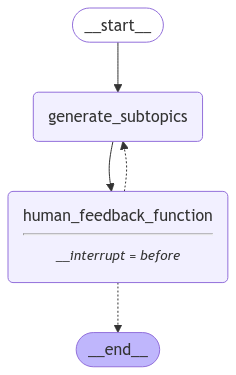

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

generate_subtopics_prompt = """
You are tasked with creating subtopics for a {writing_type}, follow these instructions carefully:
1. Carefully analyse this topic to understand what it is and what is required of it:
{topic}
2. Examine any editorial feedback that has been optionally provided to guide in the creation of subtopics
{human_feedback}
3. Dertemine the most interesting sub topics and pick the top {max_subtopics}
4. In the content part put an empty string for now
"""
def generate_subtopics(state: GenerateWritingState):
    
    writing_type = state["writing_type"]
    topic = state["topic"]
    human_feedback = state.get("human_feedback", None)
    max_subtopics = state["max_subtopics"]
    
    formatted_prompt = generate_subtopics_prompt.format(writing_type = writing_type, topic = topic, human_feedback = human_feedback, max_subtopics = max_subtopics)
    
    structured_llm = llm.with_structured_output(SubTopicList)
    
    subtopics = structured_llm.invoke([SystemMessage(content=formatted_prompt)] + [HumanMessage(content="generate subtopics")])
    
    return {"subtopics" : subtopics.subTopics}

def human_feedback_function(state: GenerateWritingState):
    pass

def subtopics_confirmation(state: GenerateWritingState):
    human_feedback = state.get("human_feedback", None)
    
    if human_feedback:
        print("am deciding loop", human_feedback)
        return "generate_subtopics"
    print("am deciding to end", human_feedback)
    return END

# create a graph builder
builder = StateGraph(GenerateWritingState)

# Add a node
builder.add_node(generate_subtopics, "generate_subtopics")
builder.add_node(human_feedback_function, "human_feedback_function")

# add edges
builder.add_edge(START, "generate_subtopics")
builder.add_edge("generate_subtopics", "human_feedback_function")
builder.add_conditional_edges("human_feedback_function", subtopics_confirmation, ["generate_subtopics", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_function'],checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))



In [6]:
topic = "what is Artificial intelligence"
writing_type = "Blog"
max_subtopics = 5
template = """
Title: [Enter the blog title here]

Introduction:
[Write an engaging introduction that explains what the blog will cover and why it's important.]

Table of Contents:
1. [What is Topic?]
2. [Why is Topic Important?]
3. [Key Insights]
4. [How to Implement Topic]
5. [Challenges and Solutions]
6. [Conclusion]

Body:
1. What is Topic?
   [Explain the topic clearly with examples or analogies.]

2. Why is Topic Important?
   [Discuss the significance of the topic with supporting data or real-world examples.]

3. Key Insights:
   - [Key Insight 1]
   - [Key Insight 2]
   - [Key Insight 3]

4. How to Implement Topic:
   - Step 1: [Explain step 1]
   - Step 2: [Explain step 2]
   - Step 3: [Explain step 3]

5. Challenges and Solutions:
   - Challenge 1: [Describe challenge]
     - Solution: [Provide solution]
   - Challenge 2: [Describe challenge]
     - Solution: [Provide solution]

Conclusion:
[Summarize the blog's key points and end with a call-to-action or final thoughts.]

References/Further Reading:
- [Reference 1]
- [Reference 2]
"""

thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"topic":topic, "writing_type": writing_type, "max_subtopics": max_subtopics, "template": template }, thread)


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Types of Artificial Intelligence', content=''),
  SubTopic(title='Applications of AI in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in AI Development', content='')],
 'max_subtopics': 5,
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the significance of the topic with supporting data or real-world examples.]\n\n3. 

In [7]:
state = graph.get_state(thread)
state.values

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Types of Artificial Intelligence', content=''),
  SubTopic(title='Applications of AI in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in AI Development', content='')],
 'max_subtopics': 5,
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the topic clearly with examples or analogies.]\n\n2. Why is Topic Important?\n   [Discuss the significance of the topic with supporting data or real-world examples.]\n\n3. 

In [8]:
graph.update_state(thread, {"human_feedback":"Dont add the history and all that, am interested in topics like the difference between ai and ml, what is gen ai"})
# graph.get_state(thread).values

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbfeef-1a85-64dc-8002-93803ae1eb78'}}

In [9]:
state = graph.get_state(thread)
state.next

('human_feedback_function',)

In [10]:
graph.invoke(None,thread)

am deciding loop Dont add the history and all that, am interested in topics like the difference between ai and ml, what is gen ai


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Understanding Artificial Intelligence', content=''),
  SubTopic(title='The Difference Between AI and Machine Learning', content=''),
  SubTopic(title='What is General AI?', content=''),
  SubTopic(title='Applications of Artificial Intelligence in Various Industries', content=''),
  SubTopic(title='Ethical Considerations in Artificial Intelligence', content='')],
 'max_subtopics': 5,
 'human_feedback': 'Dont add the history and all that, am interested in topics like the difference between ai and ml, what is gen ai',
 'template': "\nTitle: [Enter the blog title here]\n\nIntroduction:\n[Write an engaging introduction that explains what the blog will cover and why it's important.]\n\nTable of Contents:\n1. [What is Topic?]\n2. [Why is Topic Important?]\n3. [Key Insights]\n4. [How to Implement Topic]\n5. [Challenges and Solutions]\n6. [Conclusion]\n\nBody:\n1. What is Topic?\n   [Explain the

In [11]:
graph.update_state(thread, {"human_feedback":None}, as_node= "human_feedback_function")

am deciding to end None


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbfeef-28f6-6111-8005-4c58a4f795b6'}}

In [12]:
# the graph is now at the end, lets see whats next
state = graph.get_state(thread)
state.values["subtopics"][0].title

'Understanding Artificial Intelligence'

## Generating the actual writing and human in loop for confirming the article writing
- sofar we have been able to generate the subtopics and get human feeback on these topics, now its time to generate the writing and allow the user to confirm

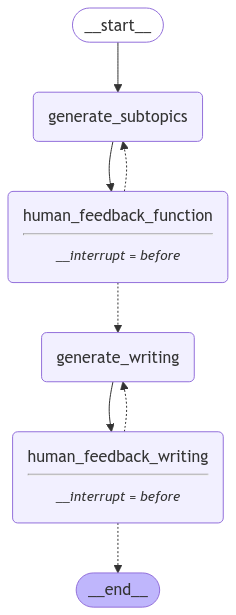

In [17]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

generate_subtopics_prompt = """
You are tasked with creating subtopics for a {writing_type}, follow these instructions carefully:
1. Carefully analyse this topic to understand what it is and what is required of it:
{topic}
2. Examine any editorial feedback that has been optionally provided to guide in the creation of subtopics
{human_feedback}
3. Dertemine the most interesting sub topics and pick the top {max_subtopics}
4. In the content part put an empty string for now
"""
def generate_subtopics(state: GenerateWritingState):
    
    writing_type = state["writing_type"]
    topic = state["topic"]
    human_feedback = state.get("human_feedback", None)
    max_subtopics = state["max_subtopics"]
    
    formatted_prompt = generate_subtopics_prompt.format(writing_type = writing_type, topic = topic, human_feedback = human_feedback, max_subtopics = max_subtopics)
    
    structured_llm = llm.with_structured_output(SubTopicList)
    
    subtopics = structured_llm.invoke([SystemMessage(content=formatted_prompt)] + [HumanMessage(content="generate subtopics")])
    print("I have generated these topics", subtopics)
    return {"subtopics" : subtopics.subTopics}

def human_feedback_function(state: GenerateWritingState):
    pass

def human_feedback_writing(state: GenerateWritingState):
    pass

def subtopics_confirmation(state: GenerateWritingState):
    human_feedback = state.get("human_feedback", None)
    
    if human_feedback:
        print("am deciding loop", human_feedback)
        return "generate_subtopics"
    print("am deciding to end", human_feedback)
    return "generate_writing"

writing_prompt = """
You are an expert in writing a {writing_type}.
You are tasked with creating a {writing_type} with these subtopics {subtopics} under this topic {topic}.
1. Analyse each subtopic and generate content under the subtopic
2. your output should stick to this template example {template}
"""
def generate_writing(state: GenerateWritingState):
    print("I have started writing")
    """
    Generate writing based on the given state.
    
    Args:
    state (GenerateWritingState): The state of the writing generation process.
    
    Return:
    writing: The generated writing update to the state.
    """
    writing_type = state["writing_type"]
    subtopics = state["subtopics"]
    template = state["template"]
    topic = state["topic"]
    formatted_string = f"'subtopics': [{', '.join([f'SubTopic(title={repr(subtopic.title)}, content={repr(subtopic.content)})' for subtopic in subtopics])}]"
    print("formatted string", formatted_string)
    print("before formatted writing")
    
    formatted_writing_prompt = writing_prompt.format(writing_type = writing_type, subtopics = formatted_string, template= template, topic = topic)
    print("formatted_writing_prompt", formatted_writing_prompt)
    response = llm.invoke([SystemMessage(content=formatted_writing_prompt)]+[HumanMessage(content="generate writing")])
    print("after calling the llm")
    
    print(response)
    return {"writing": response.content}
def writing_confirm(state: GenerateWritingState):
    writing_confirm = state.get("writing_confirm", None)
    if writing_confirm:
        return "generate_writing"
    return END

# create a graph builder
builder = StateGraph(GenerateWritingState)

# Add a node
builder.add_node(generate_subtopics, "generate_subtopics")
builder.add_node(human_feedback_function, "human_feedback_function")
builder.add_node(generate_writing, "generate_writing")
builder.add_node(human_feedback_writing, "human_feedback_writing")

# add edges
builder.add_edge(START, "generate_subtopics")
builder.add_edge("generate_subtopics", "human_feedback_function")
builder.add_conditional_edges("human_feedback_function", subtopics_confirmation, ["generate_subtopics", "generate_writing"])
builder.add_edge("generate_writing", "human_feedback_writing")
builder.add_conditional_edges("human_feedback_writing", writing_confirm, ["generate_writing", END])


# Compile
memory = MemorySaver()
graph_2 = builder.compile(interrupt_before=['human_feedback_function', 'human_feedback_writing'],checkpointer=memory)

# View
display(Image(graph_2.get_graph(xray=1).draw_mermaid_png()))



    

In [46]:
topic = "what is Artificial intelligence"
writing_type = "Blog"
max_subtopics = 3
template = """
Blog Title

Introduction
    - Brief overview of the topic
    - Hook to engage the reader

Subtopic 1: Background/Context
    - Explanation of key terms or concepts
    - Importance or relevance of the topic

Subtopic 2: Main Discussion/Analysis
    - Detailed exploration of the topic
    - Supporting arguments or evidence
    - Examples or case studies

Subtopic 3: Challenges or Considerations
    - Possible issues or complexities
    - Contrasting perspectives (if applicable)

Subtopic 4: Solutions/Insights
    - Proposed solutions or strategies
    - Key takeaways or lessons

Conclusion
    - Summary of main points
    - Call to action or closing thoughts

Optional: References/Further Reading
    - Links or citations for deeper exploration
"""

thread_2 = {"configurable": {"thread_id": "2"}}
graph_2.invoke({"topic":topic, "writing_type": writing_type, "max_subtopics": max_subtopics, "template": template }, thread_2)


I have generated these topics subTopics=[SubTopic(title='Introduction to Artificial Intelligence', content=''), SubTopic(title='History and Evolution of AI', content=''), SubTopic(title='Applications of Artificial Intelligence in Various Industries', content='')]


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Applications of Artificial Intelligence in Various Industries', content='')],
 'max_subtopics': 3,
 'template': '\nBlog Title\n\nIntroduction\n    - Brief overview of the topic\n    - Hook to engage the reader\n\nSubtopic 1: Background/Context\n    - Explanation of key terms or concepts\n    - Importance or relevance of the topic\n\nSubtopic 2: Main Discussion/Analysis\n    - Detailed exploration of the topic\n    - Supporting arguments or evidence\n    - Examples or case studies\n\nSubtopic 3: Challenges or Considerations\n    - Possible issues or complexities\n    - Contrasting perspectives (if applicable)\n\nSubtopic 4: Solutions/Insights\n    - Proposed solutions or strategies\n    - Key takeaways or lessons\n\nConclusion\n    - Summary of main points

In [47]:
graph_2.update_state(thread_2,{"human_feedback": "dont talk about the history, talk about the types of of AI and gen AI"}, as_node="human_feedback_function")

am deciding loop dont talk about the history, talk about the types of of AI and gen AI


{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6d44-32a8-64ad-8002-ab886d2c84bc'}}

In [48]:
graph_2.get_state(thread_2).values

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Introduction to Artificial Intelligence', content=''),
  SubTopic(title='History and Evolution of AI', content=''),
  SubTopic(title='Applications of Artificial Intelligence in Various Industries', content='')],
 'max_subtopics': 3,
 'human_feedback': 'dont talk about the history, talk about the types of of AI and gen AI',
 'template': '\nBlog Title\n\nIntroduction\n    - Brief overview of the topic\n    - Hook to engage the reader\n\nSubtopic 1: Background/Context\n    - Explanation of key terms or concepts\n    - Importance or relevance of the topic\n\nSubtopic 2: Main Discussion/Analysis\n    - Detailed exploration of the topic\n    - Supporting arguments or evidence\n    - Examples or case studies\n\nSubtopic 3: Challenges or Considerations\n    - Possible issues or complexities\n    - Contrasting perspectives (if applicable)\n\nSubtopic 4: Solutions/Insights\n    - Proposed solutio

In [49]:
graph_2.invoke(None, thread_2)

I have generated these topics subTopics=[SubTopic(title='Understanding Narrow AI', content=''), SubTopic(title='Exploring General AI', content=''), SubTopic(title='The Rise of Generative AI', content='')]


{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Understanding Narrow AI', content=''),
  SubTopic(title='Exploring General AI', content=''),
  SubTopic(title='The Rise of Generative AI', content='')],
 'max_subtopics': 3,
 'human_feedback': 'dont talk about the history, talk about the types of of AI and gen AI',
 'template': '\nBlog Title\n\nIntroduction\n    - Brief overview of the topic\n    - Hook to engage the reader\n\nSubtopic 1: Background/Context\n    - Explanation of key terms or concepts\n    - Importance or relevance of the topic\n\nSubtopic 2: Main Discussion/Analysis\n    - Detailed exploration of the topic\n    - Supporting arguments or evidence\n    - Examples or case studies\n\nSubtopic 3: Challenges or Considerations\n    - Possible issues or complexities\n    - Contrasting perspectives (if applicable)\n\nSubtopic 4: Solutions/Insights\n    - Proposed solutions or strategies\n    - Key takeaways or lessons\n\nConclus

In [50]:
graph_2.update_state(thread_2,{"human_feedback": None})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa6d45-028f-6214-8004-8db8f5710d8d'}}

In [51]:
graph_2.get_state(thread_2).values

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Understanding Narrow AI', content=''),
  SubTopic(title='Exploring General AI', content=''),
  SubTopic(title='The Rise of Generative AI', content='')],
 'max_subtopics': 3,
 'template': '\nBlog Title\n\nIntroduction\n    - Brief overview of the topic\n    - Hook to engage the reader\n\nSubtopic 1: Background/Context\n    - Explanation of key terms or concepts\n    - Importance or relevance of the topic\n\nSubtopic 2: Main Discussion/Analysis\n    - Detailed exploration of the topic\n    - Supporting arguments or evidence\n    - Examples or case studies\n\nSubtopic 3: Challenges or Considerations\n    - Possible issues or complexities\n    - Contrasting perspectives (if applicable)\n\nSubtopic 4: Solutions/Insights\n    - Proposed solutions or strategies\n    - Key takeaways or lessons\n\nConclusion\n    - Summary of main points\n    - Call to action or closing thoughts\n\nOptional: Ref

In [52]:
graph_2.invoke(None, thread_2)

am deciding to end None
I have started writing
formatted string 'subtopics': [SubTopic(title='Understanding Narrow AI', content=''), SubTopic(title='Exploring General AI', content=''), SubTopic(title='The Rise of Generative AI', content='')]
before formatted writing
formatted_writing_prompt 
You are an expert in writing a Blog.
You are tasked with creating a Blog with these subtopics 'subtopics': [SubTopic(title='Understanding Narrow AI', content=''), SubTopic(title='Exploring General AI', content=''), SubTopic(title='The Rise of Generative AI', content='')] under this topic what is Artificial intelligence.
1. Analyse each subtopic and generate content under the subtopic
2. your output should stick to this template example 
Blog Title

Introduction
    - Brief overview of the topic
    - Hook to engage the reader

Subtopic 1: Background/Context
    - Explanation of key terms or concepts
    - Importance or relevance of the topic

Subtopic 2: Main Discussion/Analysis
    - Detailed expl

{'topic': 'what is Artificial intelligence',
 'writing_type': 'Blog',
 'subtopics': [SubTopic(title='Understanding Narrow AI', content=''),
  SubTopic(title='Exploring General AI', content=''),
  SubTopic(title='The Rise of Generative AI', content='')],
 'max_subtopics': 3,
 'template': '\nBlog Title\n\nIntroduction\n    - Brief overview of the topic\n    - Hook to engage the reader\n\nSubtopic 1: Background/Context\n    - Explanation of key terms or concepts\n    - Importance or relevance of the topic\n\nSubtopic 2: Main Discussion/Analysis\n    - Detailed exploration of the topic\n    - Supporting arguments or evidence\n    - Examples or case studies\n\nSubtopic 3: Challenges or Considerations\n    - Possible issues or complexities\n    - Contrasting perspectives (if applicable)\n\nSubtopic 4: Solutions/Insights\n    - Proposed solutions or strategies\n    - Key takeaways or lessons\n\nConclusion\n    - Summary of main points\n    - Call to action or closing thoughts\n\nOptional: Ref

In [53]:
graph_2.get_state(thread_2).values["writing"]

'**Blog Title: Understanding the Different Facets of Artificial Intelligence**\n\n**Introduction**\n- Artificial Intelligence (AI) is transforming the way we live, work, and interact with technology. From virtual assistants to self-driving cars, AI is becoming an integral part of our daily lives.\n- As AI continues to evolve, it\'s crucial to understand its different forms and implications. This blog will delve into the various types of AI, including Narrow AI, General AI, and the emerging field of Generative AI.\n\n**Subtopic 1: Understanding Narrow AI**\n- Narrow AI, also known as Weak AI, refers to AI systems designed to perform a specific task. Unlike humans, these systems do not possess general intelligence or consciousness.\n- The importance of Narrow AI lies in its ability to automate repetitive tasks, enhance efficiency, and provide specialized solutions. Examples include voice assistants like Siri and Alexa, recommendation algorithms on Netflix, and customer service chatbots.\

**Blog Title: Understanding the Different Facets of Artificial Intelligence**\n\n**Introduction**\n- Artificial Intelligence (AI) is transforming the way we live, work, and interact with technology. From virtual assistants to self-driving cars, AI is becoming an integral part of our daily lives.\n- As AI continues to evolve, it\'s crucial to understand its different forms and implications. This blog will delve into the various types of AI, including Narrow AI, General AI, and the emerging field of Generative AI.\n\n**Subtopic 1: Understanding Narrow AI**\n- Narrow AI, also known as Weak AI, refers to AI systems designed to perform a specific task. Unlike humans, these systems do not possess general intelligence or consciousness.\n- The importance of Narrow AI lies in its ability to automate repetitive tasks, enhance efficiency, and provide specialized solutions. Examples include voice assistants like Siri and Alexa, recommendation algorithms on Netflix, and customer service chatbots.\n\n**Subtopic 2: Exploring General AI**\n- General AI, or Strong AI, is the concept of machines possessing the ability to understand, learn, and apply intelligence across a wide range of tasks, similar to human cognitive abilities.\n- While General AI remains largely theoretical, its potential impact is profound. It could revolutionize industries by performing complex tasks that require human-like understanding and decision-making. However, achieving General AI poses significant technical and ethical challenges.\n\n**Subtopic 3: The Rise of Generative AI**\n- Generative AI refers to AI systems capable of creating new content, such as text, images, or music, by learning patterns from existing data. This field has gained attention with advancements in models like GPT-3 and DALL-E.\n- Generative AI offers exciting possibilities, from creative content generation to enhancing design processes. However, it also raises concerns about originality, copyright, and the potential for misuse in creating deepfakes or misinformation.\n\n**Subtopic 4: Challenges or Considerations**\n- The development of AI, particularly General and Generative AI, presents challenges such as ethical considerations, data privacy, and the potential for job displacement.\n- There are contrasting perspectives on AI\'s future, with some viewing it as a tool for progress and others warning of its risks. Balancing innovation with ethical responsibility is crucial.\n\n**Subtopic 5: Solutions/Insights**\n- To address these challenges, it is essential to establish robust ethical guidelines and regulatory frameworks for AI development and deployment.\n- Encouraging interdisciplinary collaboration and public engagement can help ensure AI technologies are developed responsibly and inclusively. Key takeaways include the need for transparency, accountability, and continuous learning.\n\n**Conclusion**\n- AI is a multifaceted field with the potential to reshape our world. Understanding its different forms and implications is vital for harnessing its benefits while mitigating risks.\n- As we continue to explore AI\'s possibilities, it is crucial to remain informed and engaged in discussions about its development and impact.\n\n**Optional: References/Further Reading**\n- "Artificial Intelligence: A Guide to Intelligent Systems" by Michael Negnevitsky\n- "Superintelligence: Paths, Dangers, Strategies" by Nick Bostrom\n- OpenAI\'s research on Generative Pre-trained Transformers (GPT)